# **Manifest:**

### Mount Drive & Project Path

In [ ]:
# mount drive & PROJECT_PATH
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, sys, pprint
PROJECT_PATH = "/content/drive/MyDrive/D2R Model"   # <<-- update if different
assert os.path.isdir(PROJECT_PATH), f"PROJECT_PATH not found: {PROJECT_PATH}"
print("PROJECT_PATH:", PROJECT_PATH)
print("Contents:", sorted(os.listdir(PROJECT_PATH))[:50])

# make sure Python can import your dataloader
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

Mounted at /content/drive
PROJECT_PATH: /content/drive/MyDrive/D2R Model
Contents: ['D2R Dataset', '__pycache__', 'd2r_dataloader.py', 'frames', 'manifest.jsonl', 'manifest_backups', 'masks', 'models', 'test_manifest.jsonl', 'train_manifest.jsonl', 'val_manifest.jsonl']


In [ ]:
# Build fresh manifest for vid1..vid300 for 6 categories
import os, json, cv2
from pathlib import Path
from glob import glob
from tqdm import tqdm
import random

# ---------- USER / PROJECT PATH (update if different) ----------
PROJECT_PATH = "/content/drive/MyDrive/D2R Model"
ROOT_DATASET_DIR = os.path.join(PROJECT_PATH, "D2R Dataset")
FRAMES_ROOT = os.path.join(PROJECT_PATH, "frames")
MASKS_ROOT  = os.path.join(PROJECT_PATH, "masks")

OUTPUT_MANIFEST = os.path.join(PROJECT_PATH, "manifest.jsonl")
TRAIN_SPLIT = os.path.join(PROJECT_PATH, "train_manifest.jsonl")
VAL_SPLIT   = os.path.join(PROJECT_PATH, "val_manifest.jsonl")
TEST_SPLIT  = os.path.join(PROJECT_PATH, "test_manifest.jsonl")

VIDEO_EXT = (".avi", ".mp4", ".mov", ".mkv")
TARGET_COUNT_PER_CAT = 300   # vid1..vid300
RANDOM_SEED = 42

# categories we want (6 classes)
CATEGORIES = [
    "Forgery_Object_deletion",
    "Forgery_frame_insertion",
    "Forgery_horizontal_flipping",
    "Forgery_vertical_flipping",
    "Forgery_zooming_frames",
    "Original"
]

assert os.path.isdir(PROJECT_PATH), f"PROJECT_PATH not found: {PROJECT_PATH}"
assert os.path.isdir(ROOT_DATASET_DIR), f"ROOT_DATASET_DIR not found: {ROOT_DATASET_DIR}"

def find_video_for_vid(videos_dir, vid):
    """Find video file in videos_dir whose stem equals or startswith vid (try many extensions)."""
    if not videos_dir or not os.path.isdir(videos_dir):
        return None
    # exact stem match or startswith (handles vid1, vid01, vid001)
    for ext in VIDEO_EXT:
        cand = os.path.join(videos_dir, f"{vid}{ext}")
        if os.path.exists(cand):
            return cand
    # fallback: search any file whose stem startswith vid
    for p in Path(videos_dir).iterdir():
        if not p.is_file():
            continue
        stem = p.stem.lower()
        if stem == vid.lower() or stem.startswith(vid.lower()):
            if p.suffix.lower() in VIDEO_EXT:
                return str(p)
    # fallback: glob search for vid anywhere in name
    for ext in VIDEO_EXT:
        for p in glob(os.path.join(videos_dir, f"*{vid}*{ext}")):
            return p
    return None

def video_metadata_safe(vpath):
    fps = 30.0
    n_frames = 0
    w = 0; h = 0
    try:
        cap = cv2.VideoCapture(vpath)
        if cap.isOpened():
            fps = float(cap.get(cv2.CAP_PROP_FPS) or fps)
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
        cap.release()
    except Exception:
        pass
    return fps, n_frames, [w, h]

entries = []
missing_videos = []
for cat in CATEGORIES:
    # determine video directory & annotation dir depending on category
    cat_dir = os.path.join(ROOT_DATASET_DIR, cat)
    if cat.lower().startswith("original"):
        videos_dir = cat_dir
        ann_dir = None
    else:
        videos_dir = os.path.join(cat_dir, "tampered_videos")
        ann_dir = os.path.join(cat_dir, "annotations")

    # iterate vid1..vid300
    for i in range(1, TARGET_COUNT_PER_CAT + 1):
        vid_name = f"vid{i}"          # expects names like vid1, vid2, ...
        vpath = find_video_for_vid(videos_dir, vid_name)
        if vpath is None:
            # not found -> warn and skip
            missing_videos.append({"category": cat, "video_id": vid_name, "expected_dir": videos_dir})
            # don't append an entry if video missing
            continue

        # frames dir candidate
        frames_dir = os.path.join(FRAMES_ROOT, cat, f"{vid_name}_frames")
        if not os.path.isdir(frames_dir):
            frames_dir = None

        # annotation path candidate (if exists)
        ann_path = None
        if ann_dir:
            cand = os.path.join(ann_dir, f"{vid_name}_annotations.json")
            if os.path.exists(cand):
                ann_path = cand
            else:
                # try alternative naming with hyphen/underscore variations
                for alt in (f"{vid_name}_annotations.json", f"{vid_name}-annotations.json", f"{vid_name}.json"):
                    cand2 = os.path.join(ann_dir, alt)
                    if os.path.exists(cand2):
                        ann_path = cand2
                        break

        # mask dir (only for object deletion will exist, but we include conditionally)
        mask_dir = None
        if "object" in cat.lower():
            cand_mask = os.path.join(MASKS_ROOT, cat, f"{vid_name}_masks")
            if os.path.isdir(cand_mask):
                mask_dir = cand_mask

        fps, n_frames, resolution = video_metadata_safe(vpath)

        entry = {
            "video_id": vid_name,
            "category": cat,
            "video_path": os.path.normpath(vpath),
            "frames_dir": os.path.normpath(frames_dir) if frames_dir else None,
            "annotation_path": os.path.normpath(ann_path) if ann_path else None,
            "mask_dir": os.path.normpath(mask_dir) if mask_dir else None,
            "fps": float(fps),
            "n_frames": int(n_frames),
            "resolution": [int(resolution[0]), int(resolution[1])]
        }
        entries.append(entry)

# Shuffle and split (70/15/15)
random.seed(RANDOM_SEED)
random.shuffle(entries)
n = len(entries)
train_end = int(0.70 * n)
val_end = train_end + int(0.15 * n)

# overwrite files (no backups)
for path, subset in [
    (OUTPUT_MANIFEST, entries),
    (TRAIN_SPLIT, entries[:train_end]),
    (VAL_SPLIT,   entries[train_end:val_end]),
    (TEST_SPLIT,  entries[val_end:])
]:
    with open(path, "w", encoding="utf-8") as f:
        for e in subset:
            f.write(json.dumps(e) + "\n")

# summary
print("Wrote manifest files (overwritten):")
print("  master:", OUTPUT_MANIFEST)
print("  train :", TRAIN_SPLIT, "->", len(entries[:train_end]))
print("  val   :", VAL_SPLIT, "->", len(entries[train_end:val_end]))
print("  test  :", TEST_SPLIT, "->", len(entries[val_end:]))
print(f"Total entries in master manifest: {len(entries)}")

if missing_videos:
    print(f"\nWARNING: {len(missing_videos)} expected videos were missing (skipped). Sample missing:")
    for m in missing_videos[:10]:
        print(" ", m)
else:
    print("All vid1..vid300 found for the selected categories (good).")


Wrote manifest files (overwritten):
  master: /content/drive/MyDrive/D2R Model/manifest.jsonl
  train : /content/drive/MyDrive/D2R Model/train_manifest.jsonl -> 1260
  val   : /content/drive/MyDrive/D2R Model/val_manifest.jsonl -> 270
  test  : /content/drive/MyDrive/D2R Model/test_manifest.jsonl -> 270
Total entries in master manifest: 1800
All vid1..vid300 found for the selected categories (good).


In [ ]:
# list_missing_for_extraction.py
import os, json
PROJECT_PATH = "/content/drive/MyDrive/D2R Model"
MANIFEST = os.path.join(PROJECT_PATH, "test_manifest.jsonl")

missing = []
with open(MANIFEST, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        cat = obj["category"].lower()
        if ("original" in cat) or ("object" in cat and "delet" in cat):
            fdir = obj.get("frames_dir")
            if not (fdir and os.path.isdir(fdir)):
                missing.append((obj["video_id"], obj["category"], obj.get("video_path")))
print(f"Missing frames (should be extracted): {len(missing)}")
for row in missing[:25]:
    print(row)

Missing frames (should be extracted): 0


In [ ]:
# import the dataloader module saved in Drive
import sys, os
sys.path.append(PROJECT_PATH)   # so Python can import d2r_dataloader.py from Drive

from d2r_dataloader import dataset_from_manifest
manifest_up = "/content/drive/MyDrive/D2R Model/manifest.jsonl"
ds = dataset_from_manifest(manifest_up, load_frames=False, clip_len=None, video_fallback=False)

In [ ]:
# Create dataset from test manifest (fast: no image loading)
TEST_MANIFEST = os.path.join(PROJECT_PATH, "test_manifest.jsonl")
print("Test manifest path:", TEST_MANIFEST)
assert os.path.exists(TEST_MANIFEST), "test_manifest.jsonl not found in project folder"

# Create dataset: don't load frames into memory (fast)
test_ds = dataset_from_manifest(TEST_MANIFEST, load_frames=False, clip_len=None, video_fallback=False)
print("Test dataset size:", len(test_ds))


Test manifest path: /content/drive/MyDrive/D2R Model/test_manifest.jsonl
Test dataset size: 270


In [ ]:
# Inspect first N samples (metadata only)
import json
N=5
for i in range(min(N, len(test_ds))):
    s = test_ds[i]
    print("="*60)
    print(f"Sample idx: {i}")
    print("video_id:", s["video_id"])
    print("category:", s["category"])
    print("video_path:", s["video_path"])
    print("frames_dir:", s["frames_dir"])
    print("mask_dir:", s["mask_dir"])
    print("n_frames (meta):", s["meta"]["n_frames"])
    print("found frames files:", len(s["frames_paths"]))
    print("found masks files:", len(s["mask_paths"]) if s["mask_paths"] else 0)
    ann = s["annotation"]
    print("annotation exists:", bool(ann))
    if ann:
        print("annotation keys:", list(ann.keys()))
        print("normalized_affected_frames (len):", len(ann.get("normalized_affected_frames", [])))
    print("selected_indices (first 10):", s["selected_indices"][:10])

Sample idx: 0
video_id: vid121
category: Forgery_Object_deletion
video_path: /content/drive/MyDrive/D2R Model/D2R Dataset/Forgery_Object_deletion/tampered_videos/vid121.avi
frames_dir: /content/drive/MyDrive/D2R Model/frames/Forgery_Object_deletion/vid121_frames
mask_dir: /content/drive/MyDrive/D2R Model/masks/Forgery_Object_deletion/vid121_masks
n_frames (meta): 100
found frames files: 100
found masks files: 1
annotation exists: True
annotation keys: ['video_name', 'operation', 'affected_frames', 'normalized_affected_frames']
normalized_affected_frames (len): 0
selected_indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Sample idx: 1
video_id: vid93
category: Forgery_zooming_frames
video_path: /content/drive/MyDrive/D2R Model/D2R Dataset/Forgery_zooming_frames/tampered_videos/vid93.avi
frames_dir: /content/drive/MyDrive/D2R Model/frames/Forgery_zooming_frames/vid93_frames
mask_dir: None
n_frames (meta): 100
found frames files: 100
found masks files: 0
annotation exists: True
annotatio

Viewing sample: vid121 Forgery_Object_deletion
Frames dir: /content/drive/MyDrive/D2R Model/frames/Forgery_Object_deletion/vid121_frames


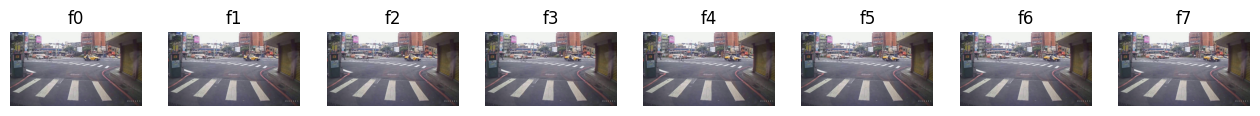

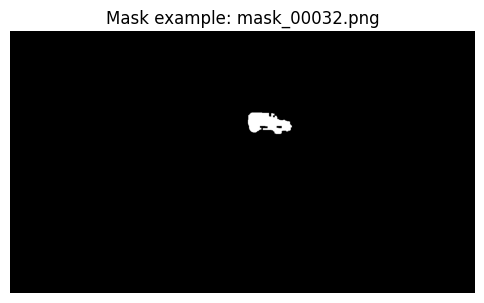

In [ ]:
# Visual check for a sample (loads a few frames from disk)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# choose sample index to view
sample_idx = 0
s = test_ds[sample_idx]
print("Viewing sample:", s["video_id"], s["category"])
print("Frames dir:", s["frames_dir"])

# choose a few frame indices to show (use selected_indices)
indices = s["selected_indices"][:8]  # first 8 selected
frame_paths = s["frames_paths"]

# Display up to 8 frames
plt.figure(figsize=(16,4))
for i, idx in enumerate(indices):
    if idx < len(frame_paths):
        fp = frame_paths[idx]
        img = Image.open(fp).convert("RGB")
        plt.subplot(1, len(indices), i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"f{idx}")
plt.show()

# If masks exist, show mask corresponding to first affected frame (if available)
if s["mask_paths"]:
    mp = s["mask_paths"][0]
    mask = Image.open(mp).convert("L")
    plt.figure(figsize=(6,4))
    plt.imshow(mask, cmap='gray')
    plt.title("Mask example: " + os.path.basename(mp))
    plt.axis('off')
    plt.show()
else:
    print("No masks for this sample.")